In [1]:
import numpy as np
import argparse
import os
import sys
import random
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils,mask_backward_new
import matplotlib.pyplot as plt
# from maskbackward import mask_backward
from mask_backward_new import mask_backward, mask_eval
from utils import mask_complete , mask_makebinary,kplot, mask_filter
from utils import get_x_f_from_yfull,mask_naiveRand, apply_mask, sigmoid_binarize

sys.path.insert(0,'/home/huangz78/mri/unet/')
from unet_model import UNet

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

#### import data to test mask_backward function

In [2]:
# data_gt = np.load('/home/huangz78/data/data_gt.npz')
# datafornn = np.load('/home/huangz78/data/datafornn.npz')
data = np.load('/home/huangz78/data/traindata_x.npz')
dtyp = torch.float
xfull = torch.tensor(data['xfull'],dtype=dtyp)
fullmask = torch.tensor(data['mask'])

In [3]:
# load a mnet
from mnet import MNet
# mnet = MNet(out_size=320-24)
mnet = MNet(beta=1,in_channels=2,out_size=320-24, imgsize=(320,320),poolk=3)
checkpoint = torch.load('/home/huangz78/checkpoints/mnet.pth')
mnet.load_state_dict(checkpoint['model_state_dict'])
print('MNet loaded successfully from: ' + '/home/huangz78/checkpoints/mnet.pth')
mnet.eval()
# load a unet for maskbackward
UNET =  UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
checkpoint = torch.load('/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth')
UNET.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + '/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth' )
UNET.train()
print('nn\'s are ready')

MNet loaded successfully from: /home/huangz78/checkpoints/mnet.pth
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1.pth
nn's are ready


In [34]:
# reload(utils)
# from utils import sigmoid_binarize
reload(mask_backward_new)
from mask_backward_new import mask_backward

In [29]:
batchsize = 5
xstar = xfull[0:batchsize,:,:]

corefreq = 24
yfull = torch.fft.fftshift(F.fftn(xstar,dim=(1,2),norm='ortho')) # y is ROLLED!
lowfreqmask,_,_ = mask_naiveRand(xstar.shape[1],fix=corefreq,other=0,roll=True)

z        = apply_mask(lowfreqmask,yfull)
highmask = sigmoid_binarize(mnet(z))
# x_lf     = get_x_f_from_yfull(lowfreqmask,yfull)
# highmask = sigmoid_binarize(mnet(x_lf.view(batchsize,1,xstar.shape[1],xstar.shape[2])))

NN         = 9
alpha_grid = 10**(np.linspace(-6,-2,NN))
c_grid     = np.array([1e-4,1e-3,1e-2,1e-1,1e0])
maskloss = np.zeros((NN,5))
sparsity = np.zeros((NN,5))
########################################  
## (1) mask_backward
########################################    
maxIter_mb = 10
lr_mb      = 1e-2
budget     = 56
# alpha = 1e-5
# c = 1e-2

In [ ]:
mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                          beta=1.,alpha=1e-2,c=1e-2,\
                          maxIter=maxIter_mb,seed=0,break_limit=maxIter_mb*3//5,\
                          lr=1e-2,mode='UNET',budget=budget,normalize=False,\
                          verbose=True,dtyp=torch.float,testmode=True)

In [ ]:
c_ind = 0
for c in c_grid:
    print(f'c_ind {c_ind+1} out of {len(c_grid)}\n')
    a_ind = 0
    for alpha in alpha_grid:
        print(f'alpha_ind {a_ind+1} out of {len(alpha_grid)}\n')
        # load a unet for maskbackward
        UNET = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
        checkpoint = torch.load('/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth')
        UNET.load_state_dict(checkpoint['model_state_dict'])
        print('Unet loaded successfully from: ' + '/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth' )
        UNET.train()
        print('nn\'s are ready')
    # highmask_refined,unet = mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
    #                   beta=1.,alpha=alpha,c=c,\
    #                   maxIter=maxIter_mb,seed=0,break_limit=maxIter_mb*3//5,\
    #                   lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
    #                   verbose=True,dtyp=torch.float)
        maskloss[a_ind,c_ind],sparsity[a_ind,c_ind] = mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                          beta=1.,alpha=alpha,c=c,\
                          maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                          lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
                          dtyp=torch.float,verbose=True,testmode=True)
        a_ind += 1
    c_ind += 1

c_ind 1 out of 5

alpha_ind 1 out of 9

Unet loaded successfully from: /home/huangz78/checkpoints/unet_1.pth
nn's are ready
iter: 1, upper level loss: 0.13358692824840546
 changed rows in this batch: 0.0, loss of current mask: 0.0411144585814327%
samp. ratio: 0.30875, Recon. rel. err: 0.13314367830753326 

Iter 7, rows added: 0.4, rows reducted: 0.8
Iter 8, rows added: 3.2, rows reducted: 0.8
Iter 9, rows added: 9.2, rows reducted: 1.8
Iter 10, rows added: 14.8, rows reducted: 1.0

return at Iter ind:  10
loss of returned mask: 0.04111445217859%
samp. ratio: 0.38125, Recon. rel. err: 0.031333163380622864 

alpha_ind 2 out of 9

Unet loaded successfully from: /home/huangz78/checkpoints/unet_1.pth
nn's are ready
iter: 1, upper level loss: 0.13439561426639557
 changed rows in this batch: 0.0, loss of current mask: 0.04111420304980129%
samp. ratio: 0.30875, Recon. rel. err: 0.13314367830753326 

Iter 7, rows added: 0.4, rows reducted: 1.2
Iter 8, rows added: 3.2, rows reducted: 0.8
Iter 9,

In [ ]:
plt.figure()
plt.plot(alpha_grid,maskloss)
plt.title('mask loss')
plt.xscale('log')

plt.figure()
plt.plot(alpha_grid,sparsity,label='actual')
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),label='target')
plt.title('mask sparsity')
plt.xscale('log')

In [ ]:
maskloss.shape

Text(0.5, 0, 'alpha')

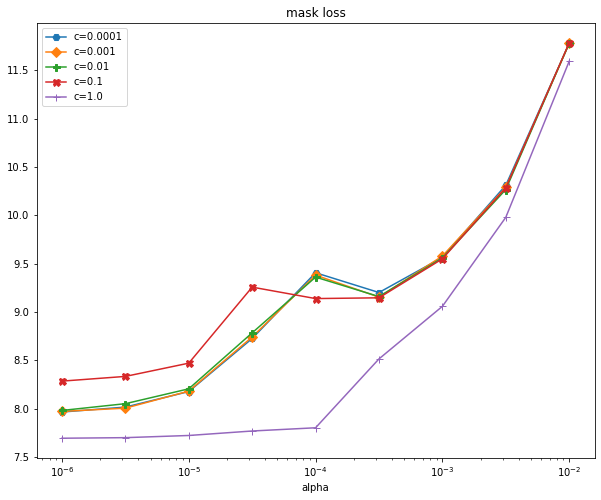

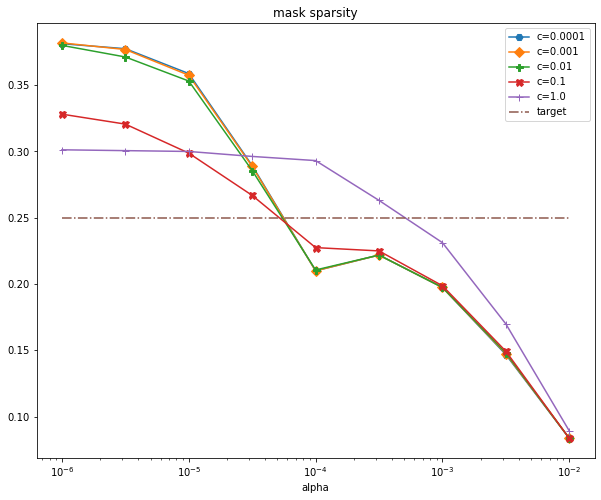

In [22]:
markers = ['H', 'D', 'P', 'X','+']
plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,maskloss[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.xlabel('alpha')
plt.title('mask loss')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,sparsity[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),'-.',label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('alpha')

In [ ]:
(highmask_refined - highmask).abs().sum()

ind = 0
highmask_refined[ind,:] - highmask[ind,:]

### old tests

In [ ]:
data_gt = np.load('/home/huangz78/data/data_gt.npz')
picind = np.random.randint(199)
xstar = data_gt['imgdata'][:,:,27]
xstar = xstar/np.max(np.abs(xstar))
# highmask = datafornn['labels'][picind,:]
plt.figure()
plt.imshow(xstar)
plt.colorbar()
plt.show()

In [ ]:
# reload(maskbackward)
# from maskbackward import mask_backward

#mode UNET:

reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

dtyp = torch.float
# unroll_block = 8; Lambda=6.1e-4; rho=1e1

# base = .05; expand = .15
# highmask = torch.zeros((round(320*(1-base))),dtype=torch.double)
# highmask[np.random.choice(round(320*(1-base)),round(320*expand),replace=False)] = 1

highmask = mask_filter(fullmask,base=round(320*0.05),roll=True)
print(highmask.shape)

In [ ]:
n_channels = 1
UNET =  UNet(n_channels=n_channels,n_classes=n_channels,bilinear=True,skip=False)
checkpoint = torch.load('/home/huangz78/checkpoints/unet_' + str(n_channels) + '.pth')
UNET.load_state_dict(checkpoint['model_state_dict'])
UNET.eval()

In [ ]:
## quick comparison between ifft recon and unet recon
imgHeg = 320; imgWid = 320
fullmask = torch.tensor( mask_complete(highmask,imgHeg,dtyp=torch.float) )
kplot(fullmask)
print('sparsity of fullmask = ',fullmask.sum().item()/imgHeg)

In [ ]:
xstar = torch.tensor(xstar,dtype=dtyp)
DTyp = torch.cfloat if dtyp==torch.float else torch.cdouble
y = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho'))
z = torch.fft.ifftshift(torch.tensordot(torch.diag(fullmask).to(DTyp),y,dims=([1],[0])))
kplot(y,roll=False,log=True)
kplot(z,roll=True,log=True)

In [ ]:
imgHeg = 320; imgWid = 320
x_ifft = torch.abs(F.ifftn(z,dim=(0,1),norm='ortho')).to(dtyp)
x_unet = UNET(x_ifft.view(1,1,imgHeg,imgWid)).detach()

print('error of x_ifft = ', torch.norm(torch.flatten(x_ifft)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )
print('error of x_unet = ', torch.norm(torch.flatten(x_unet)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )

In [ ]:
from sigpy.mri.app import TotalVariationRecon
NN = 50
Lambda_grid = 10**np.linspace(-3.5,-3,NN)
errRec = np.zeros((NN))
ind = 1

mps  = np.ones((1,imgHeg,imgWid))
y_sp = np.reshape(z.numpy(),(-1,imgHeg,imgWid))
for Lambda in Lambda_grid:
# Lambda = 10**(-6.31) 
# Lambda = 10**(-3.2755) # np.log10(Lambda_grid[np.argmin(errRec)])
    print('{} out of {}'.format(ind,NN))
    x_sp = np.fft.fftshift( np.abs(TotalVariationRecon(y_sp, mps, Lambda,show_pbar=False).run()) ) 
    x_sp = torch.tensor(x_sp)
    errRec[ind-1] = torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro')
    ind += 1
#     print('error of x_sp = ', torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro'))

plt.figure()
plt.xscale('log')
plt.plot(Lambda_grid,errRec)

In [ ]:
np.linspace(-6,-4,gridnum)[8]

In [ ]:
reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

maxIter = 200
gridnum = 10
alpha_grid = 10**np.linspace(-4.6,-4.5,gridnum)
sr_rec = np.zeros((gridnum))
mloss_rec = np.zeros(gridnum)

ind = 0
for alpha in alpha_grid:
    print('[{}/{}]  alpha {}'.format(ind+1,gridnum,alpha))
    highmask_refined,refine_mloss,init_loss = mask_backward(highmask,xstar,\
                          beta=1., alpha=alpha,maxIter=maxIter,seed=0,break_limit=maxIter//2,\
                          lr=5e-4,mode='UNET',\
                          verbose=False,dtyp=dtyp)
    print('Difference between masks: \n',highmask_refined - highmask)
#     print('Refined mask is: \n',highmask_refined)
    mloss_rec[ind] = refine_mloss
    sr_rec[ind] = (torch.sum(highmask_refined).item() + 24)/320
    ind += 1

In [ ]:
plt.figure()
plt.scatter(alpha_grid,mloss_rec,label='refined')
plt.scatter(alpha_grid,init_loss*np.ones(mloss_rec.shape),label='init.')
plt.title('mask loss')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.scatter(alpha_grid,sr_rec,label='refined')
plt.scatter(alpha_grid,0.25*np.ones(mloss_rec.shape),label='init.')
plt.title('mask sampling ratio')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

### arXiv

In [ ]:
reload(mask_backward_new)
from mask_backward_new import mask_backward

# mode ADMM:

highmask = torch.zeros((round(320*0.9)))
highmask[np.random.choice(round(320*0.9),int(320*.1),replace=False)] = 1

naive_mloss = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
highmask_refined,refine_mloss = mask_backward(highmask,xstar,\
                          beta=1., alpha=1e1,maxIter=200,unroll_block=unroll_block,seed=0,break_limit=100,\
                          lr=5e-4,mode='ADMM',Lambda=Lambda,rho=rho,\
                          verbose=True,perturb=False,perturb_freq=5,eps=1e-2)

In [ ]:
# vary sampling ratio, observe RMSE for the same image.
reload(mask_backward_new)
from mask_backward_new import mask_backward

base=0.1
r_grid = np.array([0.1,0.15,0.2])
naive_mloss = np.zeros((r_grid.size))
refine_mloss = np.zeros((r_grid.size))

sampRatio = np.zeros((r_grid.size))

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/3)

np.random.seed(0)

ind = 0
for r in r_grid:
    print('\n r {}, the {} item out of {}'.format(r,ind+1,r_grid.size))
    highmask = torch.zeros((round(320*(1-base))))
    highmask[np.random.choice(round(320*(1-base)),int(320*r),replace=False)] = 1
    
    naive_mloss[ind] = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
    highmask_refined,refine_mloss[ind] = mask_backward(highmask,xstar,seed=0,\
                              beta=1., alpha=9.5e0,maxIter=maxIter,unroll_block=unroll_block,break_limit=break_limit,\
                              lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                              verbose=True,perturb=False,perturb_freq=5,eps=1e-2)
    sampRatio[ind] = (highmask_refined.sum().item() + round(320*0.1))/320
    ind += 1

In [ ]:
print('sampRatio: ',sampRatio)
plt.figure()
plt.scatter(r_grid,naive_mloss,label='naive')
plt.scatter(sampRatio,refine_mloss,label='refined')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

In [ ]:
## find a good alpha for l1 penalty
reload(mask_backward_new); reload(utils);
from mask_backward_new import mask_backward
alpha_grid = np.linspace(1,10,10)
sparsity_ = np.zeros(alpha_grid.size)
change_count = np.zeros(alpha_grid.size)

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/2)
# add samp. ratio. = .1 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?

base = 0.05
additional = 0.125

highmask = torch.zeros((round(320*(1-base))))
highmask[np.random.choice(round(320*(1-base)),round(320*additional),replace=False)] = 1

ind = 0
for alpha in alpha_grid:
    print('\n\talpha = {}'.format(alpha))
    highmask_refined,_ = mask_backward(highmask,xstar,\
                  beta=1, alpha=alpha,maxIter=maxIter,unroll_block=unroll_block,seed=0,break_limit=break_limit,\
                  lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                  perturb=False,perturb_freq=10,verbose=True)
    sparsity_[ind] = mask_complete(highmask_refined.to(torch.double),320).sum().item()/320
    change_count[ind] = torch.abs(highmask_refined - highmask).sum().item()
    ind += 1

In [ ]:
plt.figure()
plt.scatter(alpha_grid,sparsity_,label='end')
plt.scatter(alpha_grid,(base+additional)*np.ones(alpha_grid.size),label='start')
plt.title('sparsity')
# plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

plt.figure()
plt.scatter(alpha_grid,change_count)
# plt.xscale('log')
plt.title('change count')

In [ ]:
naive_mloss = mask_eval(mask_complete(highmask,imgHeg,dtyp=dtyp),xstar,mode='UNET',UNET=UNET,dtyp=dtyp) * 100
print('naive mask loss = ',naive_mloss)